In [318]:
import h5py
import pandas as pd
import random
import numpy as np
import matplotlib.pyplot as plt
from public_ import cohen_kappa_score

from sklearn.linear_model import LogisticRegression
from sklearn.multiclass import OneVsRestClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.metrics.scorer import make_scorer

from scipy import signal
import seaborn as sns

import keras
from keras.layers import Dense, Flatten, Conv1D, MaxPooling1D, Dropout
from keras.models import Sequential

# DATA

In [236]:
# LOAD DATA

keys = ['eeg_1', 'eeg_2', 'eeg_3', 'eeg_4', 'po_ir', 'po_r', 'accelerometer_x', 'accelerometer_y', 'accelerometer_z']

train = h5py.File('train.h5', "r")
dbs = [train[key][:] for key in keys]

labels = pd.read_csv('challenge_output_data_training_file_learning_sleep_stages_from_physiological_signals_on_dreem_headband.csv', sep=';')
y = np.array(labels['label'])

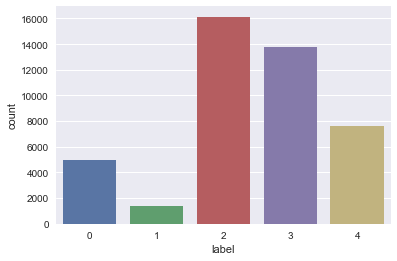

In [21]:
sns.set(style="darkgrid")
ax = sns.countplot(x='label', data=pd.DataFrame(labels['label']))

La base de données est assez desequilibrée avec par exemple la classe 1 sous-représentée et la 2 sur-représentée.

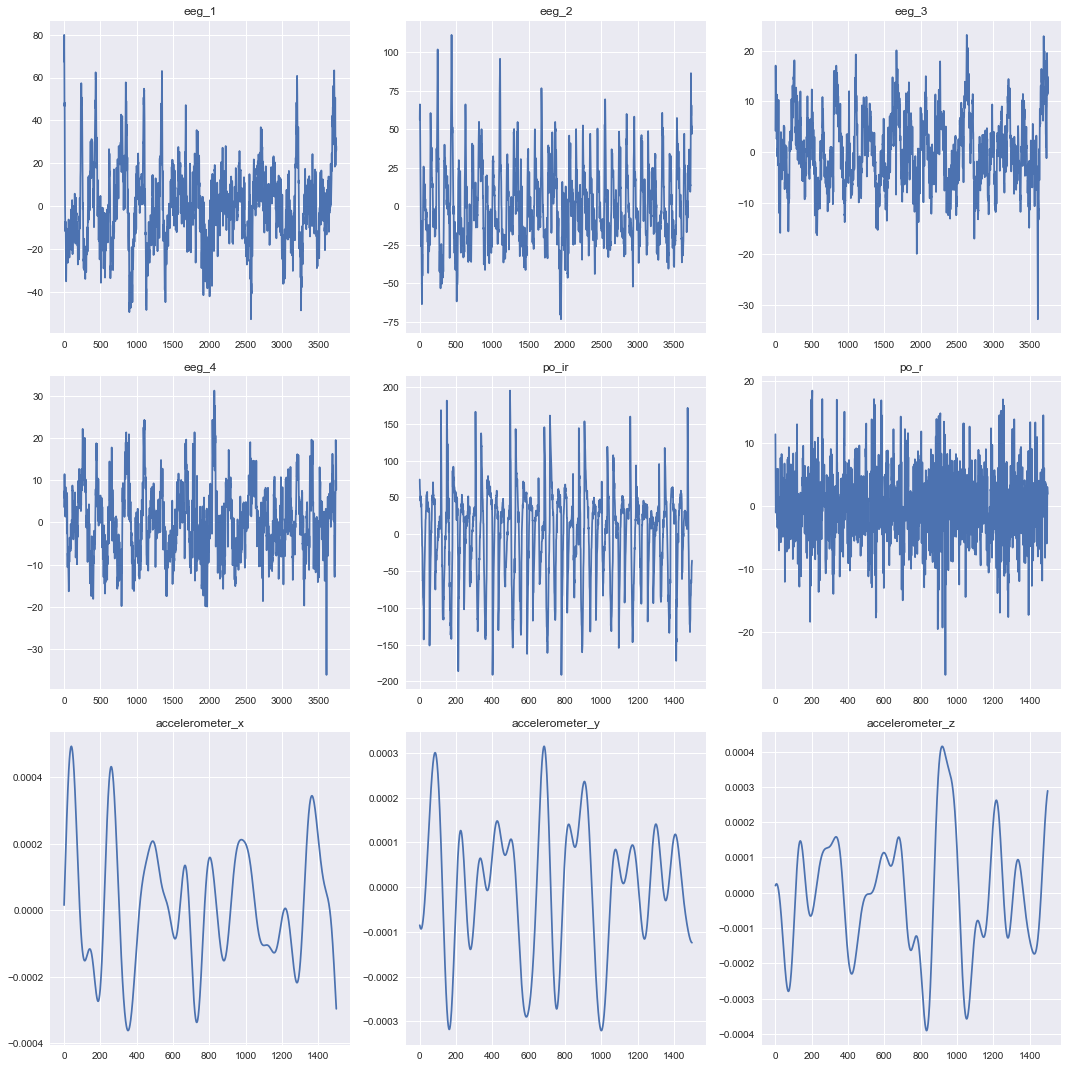

In [28]:
plt.figure(figsize=(15, 15))

for i in range(9):
    plt.subplot(331 + i)
    plt.plot(dbs[i][1])
    plt.title(keys[i])

    plt.tight_layout()
plt.show()

Chaque période de 30 secondes est représentée par 9 séries temporelles de 1500 à 3750 observations. Une réduction de la dimension de ces séries va nous permettre d'alléger considérablement le modèle et de limiter les risques de sur-apprentissage en réduisant les dégrés de liberté. L'activité cerebrale, cardiaque et respiratoire sont des phénomènes périodiques, nous allons donc utiliser la méthode de Fourier afin de réduire la taille de chaque série en conservant au maximum les informations importantes.

In [324]:
# DOWNSAMPLING

resampled_size = 384//2
resampled = [np.apply_along_axis(lambda u: signal.resample(u, resampled_size), 1, db) for db in dbs]

In [55]:
resampled[0].shape

(43830, 384)

# FEATURES

Nous calculons les features classiques de series temporelles: moyenne, écart-type, max, min et fréquence (celle qui maximise la densité spectrale de puissance du signal). 

In [4]:
# EXTRACT FEATURES

def frequency(ts):
    f, Pxx_spec = signal.periodogram(ts)
    return f[np.argmax(Pxx_spec)]

def features(ts):
    return np.array([np.mean(ts), np.std(ts), frequency(ts), np.max(ts), np.min(ts)])

In [5]:
db_list = [np.apply_along_axis(features, 1, db_) for db_ in resampled]
db = np.hstack(db_list)

db_normed = (db - db.mean(axis=0)) / db.std(axis=0)

db_normed.shape

(43830, 45)

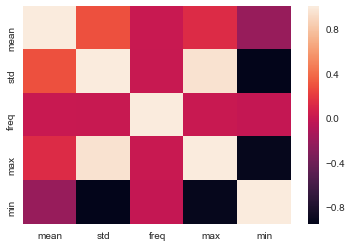

In [407]:
corr = np.corrcoef(db_normed[:, :5].transpose())

# plot the heatmap
features_label = ['mean', 'std', 'freq', 'max', 'min']
sns.heatmap(corr,xticklabels=features_label, yticklabels=features_label)
plt.show()

Le maximum et le minimum sont tout deux très fortement correlés avec l'écart type. Ces features n'apportent donc pas d'information supplémentaires et peuvent être mis à l'écart.

# Logistic regression

In [270]:
db_train, db_test, y_train, y_test = train_test_split(db, y, test_size=0.3, random_state=0)

In [101]:
clf = OneVsRestClassifier(LogisticRegression()).fit(db_train, y_train)
Out = clf.predict(db_test)
print('kappa score: ', cohen_kappa_score(Out, y_test))
print('accuracy   : ', np.mean(Out==y_test))

kappa score:  0.0322967299689
accuracy   :  0.329074454331


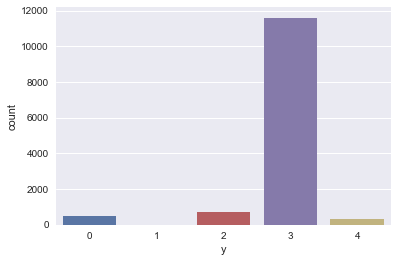

In [102]:
sns.set(style="darkgrid")
ax = sns.countplot(x='y', data=pd.DataFrame(Out, columns=['y']))

La régression logistique ne donne pas de bons résultats car les données issues des features extraites ne semblent pas être linéairement séparables. La classe 3 largement sur-représentée.

# PCA

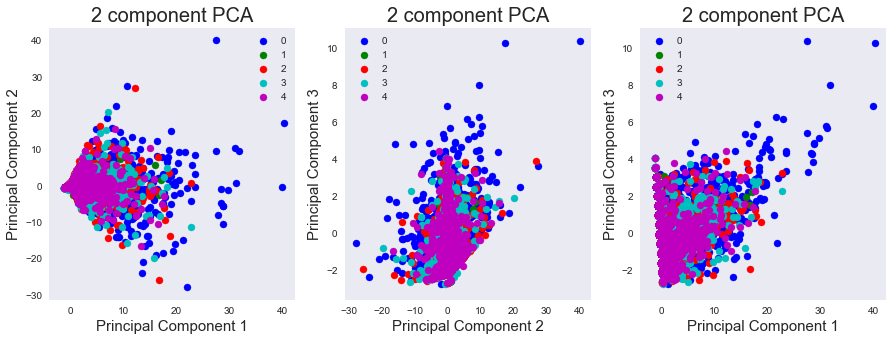

In [416]:
pca = PCA(n_components=3)
principalComponents = pca.fit_transform(db_normed[:, -5:])
principalDf = pd.DataFrame(data = principalComponents, 
                           columns = ['principal component 1', 'principal component 2', 'principal component 3'])

y_df = pd.DataFrame(y, columns=['target'])
finalDf = pd.concat([principalDf, y_df[['target']]], axis = 1)

fig = plt.figure(figsize = (15,5))
cpl = [[1,2], [2,3], [1,3]]
targets = [0, 1, 2, 3, 4]
colors = ['b', 'g', 'r', 'c', 'm']
for i in range(3):
    ax = plt.subplot2grid((1, 3), (0, i), colspan=1)
    ax.set_xlabel('Principal Component '+str(cpl[i][0]), fontsize = 15)
    ax.set_ylabel('Principal Component '+str(cpl[i][1]), fontsize = 15)
    ax.set_title('2 component PCA', fontsize = 20)
    for target, color in zip(targets,colors):
        indicesToKeep = finalDf['target'] == target
        ax.scatter(finalDf.loc[indicesToKeep, 'principal component '+str(cpl[i][0])]
                   , finalDf.loc[indicesToKeep, 'principal component '+str(cpl[i][1])]
                   , c = color
                   , s = 50)
    ax.legend(targets)
    ax.grid()

L'ACP ne permet pas de distinguer une discrimination possible entre les points. On observe néanmoins une différence entre l'état éveillé et l'état endormi. le stade de réveil a les points les plus espacés dans la projection sur les composantes principales.

# Gradient boosting

In [111]:
clf = GradientBoostingClassifier(learning_rate=1).fit(db_train, y_train)
Out = clf.predict(db_test)
print('kappa score: ', cohen_kappa_score(Out, y_test))
print('accuracy   : ', np.mean(Out==y_test))

kappa score:  0.571823240818
accuracy   :  0.694197277359


Le classifieur non linéaire Gradient Tree Boosting est un modèle bien plus efficace. Nous allons essayer de l'améliorer en estimant les meilleurs paramètres comme le taux d'apprentissage et la profondeur maximale par validation croisée.

#### Learning rate

In [118]:
scorer = make_scorer(cohen_kappa_score, greater_is_better=True)
params = dict(learning_rate=[0.1, 0.2, 0.25, 0.3, 0.4])
clf = GridSearchCV(estimator=GradientBoostingClassifier(), param_grid=params, scoring=scorer)
clf.fit(db, y)
print('best score   : ', clf.best_score_)
print('learning rate: ', clf.best_estimator_.learning_rate)

best score   :  0.581107840394
learning rate:  0.3


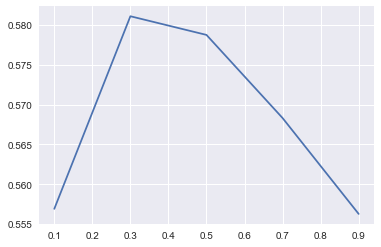

In [116]:
plt.plot(params['learning_rate'], clf.cv_results_['mean_test_score'])
plt.show()

#### Max Depth

In [409]:
# La lenteur des phases d'apprentissage lorsque la pronfondeur maximale est grande ne nous permet pas de faire de 
# validation croisée mais la taille des échantillons nous assure quand meme une certaine robustesse des estimateurs 
# des scores

max_depths = [3, 6, 9, 11, 15]
kscore = []
for max_depth in max_depths:
    clf = GradientBoostingClassifier(learning_rate=0.3, max_depth=max_depth).fit(db_train, y_train)
    Out = clf.predict(db_test)
    kscore.append(cohen_kappa_score(Out, y_test))

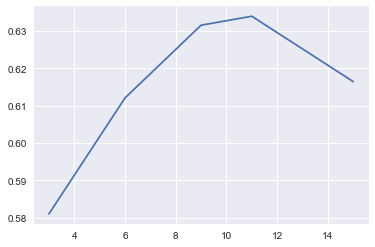

In [122]:
plt.plot(max_depths, kscore)
plt.show()

In [267]:
x_sampled, y_sampled = oversampling(db_train, y_train)

In [123]:
clf_GB = GradientBoostingClassifier(learning_rate=0.3, max_depth=11).fit(db_train, y_train)
Out = clf_GB.predict(db_test)
print('kappa score: ', cohen_kappa_score(Out, y_test))
print('accuracy   : ', np.mean(Out==y_test))

kappa score:  0.631480153816
accuracy   :  0.739295763936


### Lasso

In [147]:
from sklearn import linear_model

clf = linear_model.Lasso(alpha=0.1)
clf.fit(db_normed, [str(i) for i in y])

pd.DataFrame(clf.coef_.reshape((9, 5)), columns=['mean', 'std', 'period', 'max', 'min'])

,mean,std,period,min,max
0,-0.0,-0.000000,-0.000000,-0.0,0.0
1,0.0,-0.000000,0.000000,-0.0,0.0
2,0.0,-0.000000,-0.008759,-0.0,0.0
3,-0.0,-0.000000,-0.000000,-0.0,0.0
4,0.0,-0.000000,-0.035056,-0.0,0.0
5,0.0,0.000000,-0.088451,0.0,-0.0
6,-0.0,-0.095905,0.000000,-0.0,0.0
7,0.0,-0.000000,0.000000,-0.0,0.0
8,0.0,-0.035224,0.012359,-0.0,0.0


Les features séléctionnées par la régression Lasso correspondent à l'écart type et à la fréquence.

In [139]:
def features_light(ts):
    return np.array([np.std(ts), frequency(ts)])

db_light_list = [np.apply_along_axis(features_light, 1, db_) for db_ in resampled]
db_light = np.hstack(db_light_list)
db_light.shape

(43830, 18)

In [140]:
clf_GB_light = GradientBoostingClassifier(learning_rate=0.3, max_depth=11).fit(db_train, y_train)
Out = clf_GB_light.predict(db_test)
print('kappa score: ', cohen_kappa_score(Out, y_test))
print('accuracy   : ', np.mean(Out==y_test))

kappa score:  0.630657595627
accuracy   :  0.73868735265


Il n'y a pas de réel écart de performance en conservant uniquement l'ecart type et la fréquence.

# CNN

On a vu que les features classiques sont peu discriminantes pour classifier les stades de sommeil. Les réseaux de neurones convolutifs permettent d'extraires des features non triviales.

In [325]:
db_cnn = np.stack(resampled, axis=2)
db_cnn.shape

(43830, 192, 9)

In [403]:
# BUILD CNN

a, b, c = db_cnn.shape
#db = db_cnn.reshape(a, b, c)
input_shape = (b, c)

num_classes = 5

model = Sequential()
model.add(Conv1D(18, kernel_size=2, strides=1, activation='relu', input_shape=input_shape))
#model.add(Dropout(0.5))
model.add(MaxPooling1D(pool_size=2, strides=2))
model.add(Conv1D(36, kernel_size=2, strides=1, activation="relu"))
#model.add(Dropout(0.5))
model.add(MaxPooling1D(pool_size=2, strides=2))
model.add(Conv1D(72, kernel_size=2, strides=1, activation="relu"))
#model.add(Dropout(0.5))
model.add(MaxPooling1D(pool_size=2, strides=2))
model.add(Flatten())
#model.add(Dense(200, activation='relu'))
model.add(Dense(num_classes, activation='softmax'))

model.compile(loss=keras.losses.categorical_crossentropy,
              optimizer=keras.optimizers.adam(), #SGD(lr=0.01),
              metrics=['accuracy'])

print(model.summary())

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_79 (Conv1D)           (None, 191, 18)           342       
_________________________________________________________________
max_pooling1d_78 (MaxPooling (None, 95, 18)            0         
_________________________________________________________________
conv1d_80 (Conv1D)           (None, 94, 36)            1332      
_________________________________________________________________
max_pooling1d_79 (MaxPooling (None, 47, 36)            0         
_________________________________________________________________
conv1d_81 (Conv1D)           (None, 46, 72)            5256      
_________________________________________________________________
max_pooling1d_80 (MaxPooling (None, 23, 72)            0         
_________________________________________________________________
flatten_27 (Flatten)         (None, 1656)              0         
__________

In [298]:
class AccuracyHistory(keras.callbacks.Callback):
    def on_train_begin(self, logs={}):
        self.acc = []

    def on_epoch_end(self, batch, logs={}):
        self.acc.append(logs.get('acc'))

history = AccuracyHistory()

In [327]:
x_train, x_test, y_train, y_test = train_test_split(db_cnn, y, test_size=0.3, random_state=0)

In [369]:
def transform(x):
    output = np.zeros(5)
    output[x] = 1
    return output

y_train_transformed = np.array([transform(x) for x in y_train])
y_test_transformed = np.array([transform(x) for x in y_test])

In [384]:
model.fit(x_train, y_train_transformed,
          batch_size=128,
          epochs=15,
          verbose=1,
          validation_data=(x_test, y_test_transformed),
          callbacks=[history])

Train on 30681 samples, validate on 13149 samples
Epoch 1/15
30681/30681 [==============================] - 12s 394us/step - loss: 5.4653 - acc: 0.3676 - val_loss: 3.6345 - val_acc: 0.3886
Epoch 2/15
30681/30681 [==============================] - 10s 324us/step - loss: 3.0352 - acc: 0.4028 - val_loss: 2.5170 - val_acc: 0.4256
Epoch 3/15
30681/30681 [==============================] - 10s 328us/step - loss: 2.1714 - acc: 0.4448 - val_loss: 2.1126 - val_acc: 0.4590
Epoch 4/15
30681/30681 [==============================] - 10s 334us/step - loss: 1.7457 - acc: 0.4739 - val_loss: 1.4466 - val_acc: 0.4836
Epoch 5/15
30681/30681 [==============================] - 10s 331us/step - loss: 1.3806 - acc: 0.4844 - val_loss: 1.3192 - val_acc: 0.4802
Epoch 6/15
30681/30681 [==============================] - 10s 338us/step - loss: 1.3025 - acc: 0.4812 - val_loss: 1.4876 - val_acc: 0.3692
Epoch 7/15
30681/30681 [==============================] - 10s 336us/step - loss: 1.2928 - acc: 0.4748 - val_loss: 1.

In [385]:
output_ = model.predict(x_test)

output = np.apply_along_axis(np.argmax, axis=1, arr=output_)

print('kappa score: ', cohen_kappa_score(output, y_test))
print('accuracy   : ', np.mean(output==y_test))

kappa score:  0.248376443949
accuracy   :  0.509924709103


In [405]:
np.mean(output==2)

0.99003726519126933

Le CNN ne répond que la classe 2, la plus présente dans la base d'entraînement. Nous allons égaliser cette base par un tirage avec remise sur les autres classes.

In [386]:
#resampling

from sklearn.utils import resample

def oversampling(X, y):
    classes = list(set(y))
    idx = [np.argwhere(y==cls).flatten() for cls in classes]
    partition = [len(l) for l in idx]
    minority_oversampled = []
    majority_place = np.argmax(partition)
    majority_len = np.max(partition)
    majority_cls = classes[majority_place]
    
    minority_oversampled = []
    for i, index_list in enumerate(idx):
        if majority_place != i:
            minority = X[index_list, :]
            minority_oversampled.append(resample(minority, replace=True, n_samples=majority_len))
    
    oversampled = minority_oversampled + [X[idx[majority_place], :]]
    X_resampled = np.concatenate(oversampled)
    
    ranked_cls = classes[:majority_place] + classes[majority_place + 1:] + [majority_cls]
    y_resampled = []
    for c in ranked_cls:
        y_resampled += [c] * majority_len
    
    return X_resampled, np.array(y_resampled)

In [387]:
X_resampled, y_resampled = oversampling(x_train, y_train)
y_resampled_transformed = np.array([transform(x) for x in y_resampled])

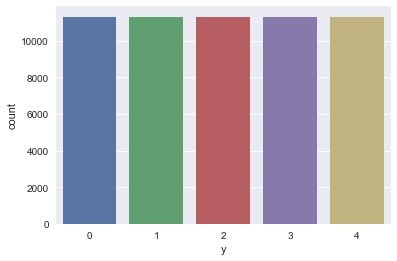

In [388]:
sns.set(style="darkgrid")
ax = sns.countplot(x='y', data=pd.DataFrame(y_resampled, columns=['y']))

In [397]:
model.fit(X_resampled, y_resampled_transformed,
          batch_size=128,
          epochs=10,
          verbose=1,
          validation_data=(x_test, y_test_transformed),
          callbacks=[history])

Train on 56595 samples, validate on 13149 samples
Epoch 1/10
56595/56595 [==============================] - 19s 342us/step - loss: 4.1610 - acc: 0.2942 - val_loss: 2.3609 - val_acc: 0.3268
Epoch 2/10
56595/56595 [==============================] - 17s 306us/step - loss: 2.0050 - acc: 0.3139 - val_loss: 1.6182 - val_acc: 0.2746
Epoch 3/10
56595/56595 [==============================] - 17s 301us/step - loss: 1.6141 - acc: 0.2580 - val_loss: 1.5637 - val_acc: 0.3068
Epoch 4/10
56595/56595 [==============================] - 17s 305us/step - loss: 1.5451 - acc: 0.3006 - val_loss: 1.4862 - val_acc: 0.2673
Epoch 5/10
56595/56595 [==============================] - 17s 308us/step - loss: 1.5428 - acc: 0.2898 - val_loss: 1.4678 - val_acc: 0.2715
Epoch 6/10
56595/56595 [==============================] - 18s 315us/step - loss: 1.5012 - acc: 0.3174 - val_loss: 1.4339 - val_acc: 0.2965
Epoch 7/10
56595/56595 [==============================] - 18s 322us/step - loss: 1.4896 - acc: 0.3241 - val_loss: 1.

In [398]:
output_ = model.predict(x_test)

output = np.apply_along_axis(np.argmax, axis=1, arr=output_)

print('kappa score: ', cohen_kappa_score(output, y_test))
print('accuracy   : ', np.mean(output==y_test))

kappa score:  0.00284842205374
accuracy   :  0.037037037037


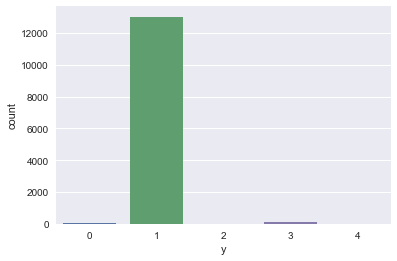

In [402]:
sns.set(style="darkgrid")
ax = sns.countplot(x='y', data=pd.DataFrame(output, columns=['y']))

On remarque que le CNN classifie la base de test exclusivement dans la classe 1. Classe qui est la moins représentée dans la base originale et qui, par conséquent, après resampling, possède les données les moins espacés.

## Bilan

La sous performance des classifieurs linéaires et l'analyse par composantes principales montrent ques les features 'classiques' ne sont pas linéairement séparables. De plus, l'analyse des corrélations et des paramètres Lasso montrent que l'ont peut travailler uniquement avec les deux variables 'ecart type' et 'fréquence' sans vraiment dégrader le modèle. Une feature qui aurait été intéressante d'exploiter est l'étude des autocorrelations des séries temporelles qui semblent à première vue stationnaires.

Le réseau de neurone convolutif a un comportement similaire à la regression logistique en ce sens qu'il favorise une classe au détriment de toutes les autres même lorsque la base d'entraînement est équilibrée. Cela engendre un Kappa score très bas. Il faudrait se plonger plus en détail dans la structure du CNN pour pouvoir prétendre classifier les périodes efficacement.

### Submission

In [138]:
test_ = h5py.File('test.h5', "r")
dbs_test = [test_[key][:] for key in keys]
resampled_test = [np.apply_along_axis(lambda u: signal.resample(u, resampled_size), 1, db) for db in dbs_test]

db_list_test = [np.apply_along_axis(features, 1, db_) for db_ in resampled_test]
db_test_ = np.hstack(db_list_test)

In [129]:
clf_GB = GradientBoostingClassifier(learning_rate=0.3, max_depth=11).fit(db, y)
output = clf_GB.predict(db_test_)
result_df = pd.DataFrame(dict(id=np.arange(len(output)), label=output))

In [133]:
result_df.to_csv('results.csv', sep=';', index=False)